In [1]:
!pwd

/mnt/erda/deep_contact


In [2]:
import sys
sys.path.append("deep_contact")
from test_erda import mount_works
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path
import json

In [4]:
PATH = Path('../data/2dsim')
SIM_DNAME = 'xml1515100'

In [5]:
SIM_DNUM='0'
psim = PATH/SIM_DNAME/SIM_DNUM

pssim=list(psim.iterdir())
simf=pssim[0]
simf

PosixPath('../data/2dsim/xml1515100/0/0_192.xml')

## read a frame from xml

In [6]:
import pandas as pd
import xml.etree.ElementTree as ET
from dataframes import dataframes_from_xml

In [7]:
bs, cs = dataframes_from_xml(ET.ElementTree(file=simf).getroot())

## Draw a configuration using matplotlib( and our util function)

In [12]:
import numpy as np
from fastai.dataset import *
from sph_plot import *

def show_frame(df:pd.DataFrame, dim=None):
    if dim is None: 
        dims=list(df.columns.values)[-4:]
        ims=[sim_to_image(df['px'],df['py'], df[dim]) for dim in dims]
        fig, axes = plt.subplots(2, 2, figsize=(16, 14), dpi= 60)
        for i,ax in enumerate(axes.flat): 
            show_colormap(ims[i], ax=ax,zoom_in=True)
            ax.set_title(dims[i])
        plt.tight_layout(pad=0.1)
    else : show_colormap(sim_to_image(df['px'],df['py'], df[dim]),zoom_in=True)

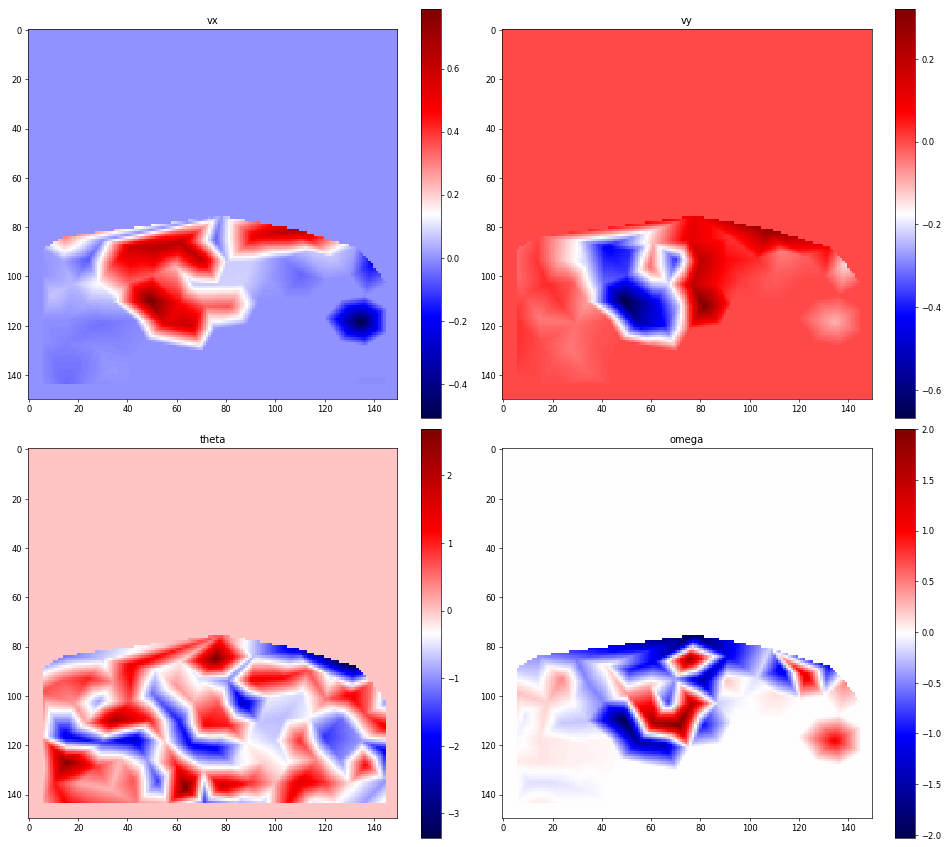

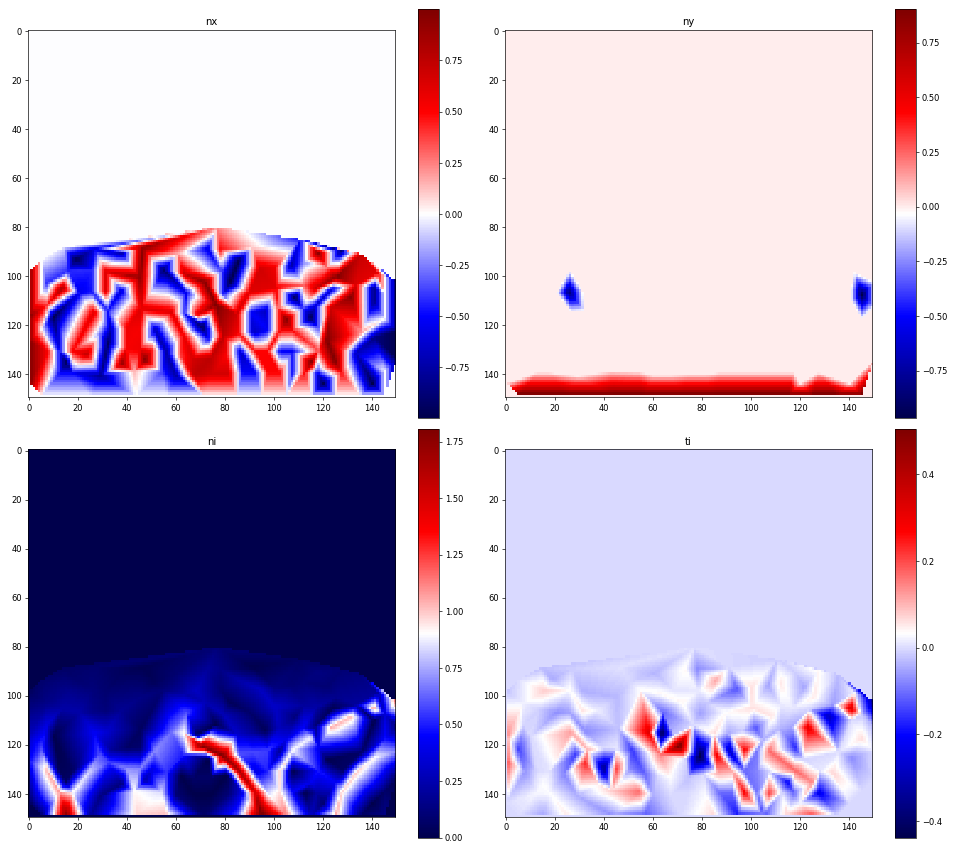

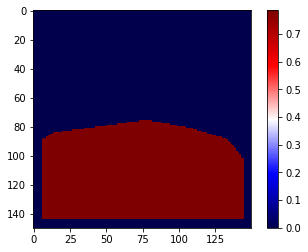

In [13]:
show_frame(bs);show_frame(cs);show_frame(bs,dim='mass')

## let's see how a few subsequent frames look like

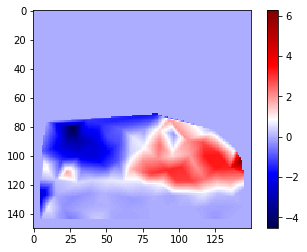

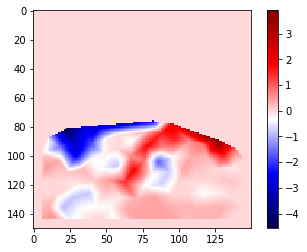

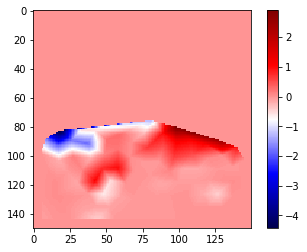

In [14]:
f1=PATH/"xml1515100/0/0_120.xml"
f2=PATH/"xml1515100/0/0_130.xml"
f3=PATH/"xml1515100/0/0_140.xml"
for f in [f1,f2,f3]:
    bs, cs = dataframes_from_xml(ET.ElementTree(file=f).getroot())
#     show_frame(bs);show_frame(cs);show_frame(bs,dim='mass')
    show_frame(bs,dim='vx')

In [132]:
sim_to_image(bs['px'],bs['py'], bs['vx']).shape

(150, 150)

# particle to grid transfer

In [29]:
from sph_grid import Grid

# a grid from lower left (0,0) to upper right (1,1)
G = Grid((0,0),(2,2),(0.2,0.2))
# positions of the points to be "splattered"
pts = [(0.5,0.5), (1.5,1.5)]
Xs,Ys = zip(*pts)
ps=Xs, Ys
# G._dist_to(ps,0.3)
# ps=(tuple([0.3,0]),tuple([0.4,0]))
# %time
# splatter the values 1 and 5 using the default poly6 2D kernel
I = G.splatter(positions=ps,values=[1,5],support_radius=0.3)
# %time
# G.splatter(ps,[2,3],0.3)
I

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.25, 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.25, 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.25, 1.25, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.25, 1.25, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])

We can see that the points end up in the right place. It is important to note that the 2D matrix is transposed in numpy. We want p_1=(0.5,0.5) to have value 1 and p_2 = (1.5,1.5) with value 5. Let's see how it looks using matplotlib

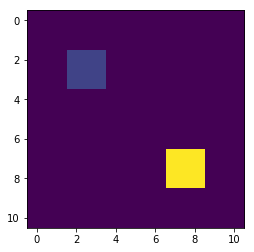

In [19]:
plt.imshow(I)

Still transposed. We'll keep that in mind. Let's test the collect method (grid back to particle). We'll query the grid close to the corners to see if we get sensible results

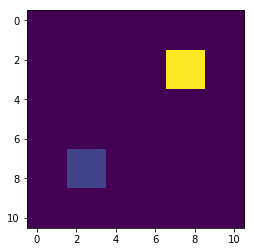

In [20]:
plt.imshow(np.flip(I,axis=0))

That's more like it

In [23]:
G.collect(I,[0.44,0.5]),G.collect(I,[0.5,0.5])# this is close to p_1

TypeError: 'float' object is not subscriptable

In [22]:
ps = [(1.5,1.4),(1.6,1.5)] # these are close to p_2 and on the same 'circle'
G.collect(I,ps), G.collect(I,[(1.5,1.5)])

([1.4852882800994103, 1.4852882800994087], [1.764865872571607])

In [137]:
G=Grid((0,0),(15,15),(0.03,0.03))
import cProfile
cp = cProfile.Profile()

In [138]:
G.clear_coefs()
ps=(bs.px.values,bs.py.values)
cp.clear()
cp.enable()
Gvx = G.splatter(ps,bs.vx.values,support_radius=1.5)
Gvy = G.splatter(ps,bs.vy.values,support_radius=1.5)
Gomega = G.splatter(ps,bs.omega.values,support_radius=1.5)
Gtheta = G.splatter(ps,bs.theta.values,support_radius=1.5)
cp.disable()
# cp.print_stats()

In [126]:
G.clear_coefs()
ps=(cs.px.values,cs.py.values)
cp.clear()
cp.enable()
Gni = G.splatter(ps,cs.ni.values,support_radius=1.5)
Gti = G.splatter(ps,cs.ti.values,support_radius=1.5)
cp.disable()
# cp.print_stats()

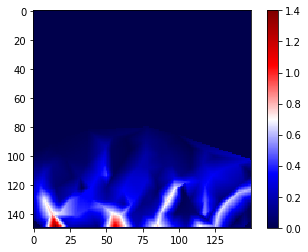

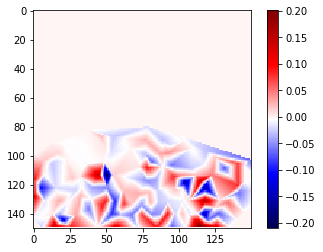

In [24]:
show_frame(cs,dim='ni')
show_frame(cs,dim='ti')

## Let's check how our grids look like

In [25]:
from sph_grid import dataframe_to_grid

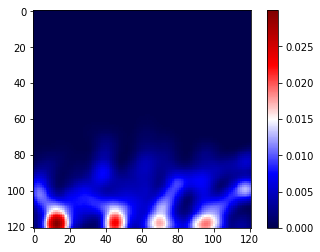

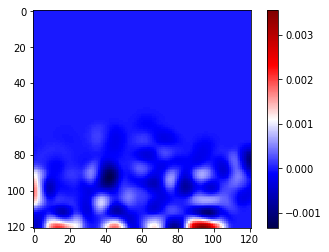

In [35]:
G=Grid((0,0),(15,15),(0.125,0.125))
show_colormap(dataframe_to_grid(G,cs,'ni',1.5),zoom_in=True)
show_colormap(dataframe_to_grid(G,cs,'ti',1.5),zoom_in=True)

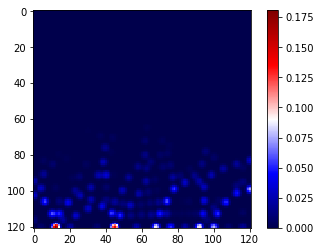

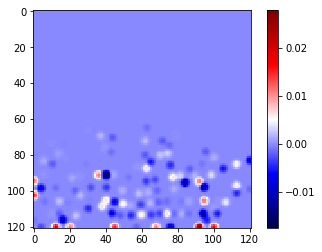

In [28]:
G=Grid((0,0),(15,15),(0.125,0.125))
show_colormap(dataframe_to_grid(G,cs,'ni',0.5),zoom_in=True)
show_colormap(dataframe_to_grid(G,cs,'ti',0.5),zoom_in=True)

# now let's create a hdf5 dataset from the folder

In [8]:
SIMFS = sorted(list((PATH/SIM_DNAME).glob("*/*.xml")))
len(SIMFS)

13822

In [11]:
import multiprocessing
import h5py
import sys

sup_rad = 0.5
res = (0.125,0.125)
G_ll = (0,0)
G_hr = (15,15)
NUM_CORES = 40
tmp_HDF5 = Path(f"/tmp/{SIM_DNAME}_res{str(res[0])}_h{sup_rad}.hdf5")
HDF5 = PATH/f"{SIM_DNAME}_res{str(res[0])}_h{sup_rad}.hdf5"
# the channels we want to splatter to the grid
body_channels = ["mass","inertia", "vx", "vy", "theta", "omega"]
contact_channels = ["nx", "ny", "ni", "ti"]
chunk_sz = 1000

def preprocess_frame(f):
    idx, frame=f.stem.split("_")
    bs, cs = dataframes_from_xml(ET.ElementTree(file=f).getroot())
    G=Grid(G_ll,G_hr,res)
    ps=(bs.px.values,bs.py.values)
    Gbody, Gcont=[],[]
    for chan in body_channels:
        Gbody.append(G.splatter(ps,bs[chan].values,support_radius=sup_rad).T)
    G.clear_coefs()
    ps=(cs.px.values,cs.py.values)
    for chan in contact_channels:
        Gcont.append(G.splatter(ps,cs[chan].values,support_radius=sup_rad).T)
    b_df = dict(zip(body_channels, Gbody))
    c_df = dict(zip(contact_channels, Gcont))
    return idx,frame, b_df, c_df


bodygrids_to_tensor = lambda r,i: np.c_[[r[0][2][j] for j in body_channels]]
contactgrids_to_tensor = lambda r,i: np.c_[[r[0][3][j] for j in contact_channels]]

def store_init(f,sz):
    with h5py.File(f, 'w') as h5f:
        asciiList=[n.encode("ascii", "ignore") for n in body_channels]
        h5f.create_dataset("body_channels",(len(asciiList),1),'S10', asciiList)
        asciiList=[n.encode("ascii", "ignore") for n in contact_channels]
        h5f.create_dataset("contact_channels",(len(asciiList),1),'S10', asciiList)
        h5f.create_dataset("sim_id",  shape=(0,), compression="gzip", dtype='i',
                           chunks=True, maxshape=(sz,))
        h5f.create_dataset("sim_fr",  shape=(0,), compression="gzip", dtype='i',
                           chunks=True, maxshape=(sz,))
        h5f.create_dataset("bodies",  shape=(0,len(body_channels),0,0), compression="gzip",
                           dtype='f', chunks=True, maxshape=(sz,None,None,None))
        h5f.create_dataset("contacts", shape=(0,len(contact_channels),0,0), compression="gzip",
                           dtype='f', chunks=True, maxshape=(sz,None,None,None))


def store_append(rs,f):
    # this is your HDF5 database:
    with h5py.File(f, 'a') as h5f:
        b_tensors,c_tensors = [],[]
        for i,_ in enumerate(rs):
            b_tensors.append(bodygrids_to_tensor(rs,i))
            c_tensors.append(contactgrids_to_tensor(rs,i))
        sim_id = [int(r[0]) for r in rs]
        sim_fr = [int(r[1]) for r in rs]
#         import pdb; pdb.set_trace()
        h5f["sim_id"].resize(h5f["sim_id"].shape[0] + len(sim_id), axis = 0)
        h5f["sim_id"][-len(sim_id):] = sim_id
        
        h5f["sim_fr"].resize(h5f["sim_fr"].shape[0] + len(sim_id), axis = 0)
        h5f["sim_fr"][-len(sim_fr):] = sim_fr
                            
        h5f["bodies"].resize(h5f["bodies"].shape[0] + len(b_tensors), axis = 0)
        if h5f["bodies"].shape[2]==0:
            h5f["bodies"].resize(b_tensors[0].shape[1], axis = 2)
        if h5f["bodies"].shape[3]==0:
            h5f["bodies"].resize(b_tensors[0].shape[2], axis = 3)
        h5f["bodies"][-len(b_tensors):] = b_tensors

        h5f["contacts"].resize(h5f["contacts"].shape[0] + len(c_tensors), axis = 0)
        if h5f["contacts"].shape[2]==0:
            h5f["contacts"].resize(c_tensors[0].shape[1], axis = 2)
        if h5f["contacts"].shape[3]==0:
            h5f["contacts"].resize(c_tensors[0].shape[2], axis = 3)
        h5f["contacts"][-len(c_tensors):] = c_tensors

def run_preprocessing():
    with multiprocessing.Pool(processes=NUM_CORES) as p:
        _max = len(SIMFS)
        print(f"Preprocessing {_max} frames. Transferring to grid ...")
        store_init(tmp_HDF5,_max)
        res=[]
        with tqdm(total=_max) as pbar:
            count = 0
            for i, r in enumerate(p.imap_unordered(preprocess_frame, SIMFS)):
                count+=1
                res.append(r)
                if len(res) == chunk_sz or count == _max:
                    save_res=res
                    res=[]
                    pbar.write(f"Saving {len(save_res)} frames to {tmp_HDF5}. DataSet size :{count} items ...")
                    store_append(save_res,tmp_HDF5)
                pbar.update()

run_preprocessing()

Preprocessing 13822 frames. Transferring to grid ...
Saving 1000 frames to /tmp/xml1515100_res0.125_h0.5.hdf5. DataSet size :1000 items ...
Saving 1000 frames to /tmp/xml1515100_res0.125_h0.5.hdf5. DataSet size :2000 items ...
Saving 1000 frames to /tmp/xml1515100_res0.125_h0.5.hdf5. DataSet size :3000 items ...
Saving 1000 frames to /tmp/xml1515100_res0.125_h0.5.hdf5. DataSet size :4000 items ...
Saving 1000 frames to /tmp/xml1515100_res0.125_h0.5.hdf5. DataSet size :5000 items ...
Saving 1000 frames to /tmp/xml1515100_res0.125_h0.5.hdf5. DataSet size :6000 items ...
Saving 1000 frames to /tmp/xml1515100_res0.125_h0.5.hdf5. DataSet size :7000 items ...
Saving 1000 frames to /tmp/xml1515100_res0.125_h0.5.hdf5. DataSet size :8000 items ...
Saving 1000 frames to /tmp/xml1515100_res0.125_h0.5.hdf5. DataSet size :9000 items ...
Saving 1000 frames to /tmp/xml1515100_res0.125_h0.5.hdf5. DataSet size :10000 items ...
Saving 1000 frames to /tmp/xml1515100_res0.125_h0.5.hdf5. DataSet size :1100

In [12]:
import shutil
shutil.copy(tmp_HDF5,HDF5)

PosixPath('erda/data/2dsim/xml1515100_res0.125_h0.5.hdf5')

In [80]:
# let's check that concatenating channels works

show_sim_img(bodygrids_to_tensor(save_res,0)[0,:,:])
show_sim_img(contactgrids_to_tensor(save_res,0)[0,:,:])

NameError: name 'bodygrids_to_tensor' is not defined